In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [4]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
def get_std_scaled(df=None):
    df_copy = df.copy()
    std_scaler = StandardScaler()
    df_copy = std_scaler.fit_transform(df_copy)
    return df_copy

def get_minmax_scaled(df=None):
    df_copy = df.copy()
    std_scaler = MinMaxScaler()
    df_copy = std_scaler.fit_transform(df_copy)
    return df_copy

In [7]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred, average = 'macro')
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, macro f1_score: {3:.4f}'.format(accuracy, precision, recall, f1))

In [8]:
train_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/train_smote.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/val.csv')
valid_df.drop(['ID'], axis=1, inplace=True)
test_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/test.csv')
test_df.drop(['ID'], axis=1, inplace=True)
print(train_df.shape, valid_df.shape, test_df.shape)
print('train_smote data 이상치 비율:', train_df[train_df['Class'] == 1].shape[0] / train_df.shape[0])
print('valid data 이상치 비율:', valid_df[valid_df['Class'] == 1].shape[0] / valid_df.shape[0])

(227500, 31) (28462, 31) (142503, 30)
train_smote data 이상치 비율: 0.5
valid data 이상치 비율: 0.0010540369615627855


In [9]:
X_train, y_train, X_valid, y_valid = train_df.iloc[:, :-1], train_df['Class'], valid_df.iloc[:, :-1], valid_df['Class']

In [15]:
params = {'n_estimators' : [1000, 2000], 'max_depth' : [6, 10, 20], 'subsample' : [0.5], 'learning_rate' : [0.1], 'gamma' : [0, 5, 10], 'max_bin' : [256, 512]}

In [ ]:
params = {'n_estimators' : [1000, 2000, 5000, 10000], 'max_depth' : [5, 10, 20, 50], 'subsample' : [0.3, 0.5, 0.8], 'learning_rate' : [0.01, 0.05, 0.1], 'gamma' : [0, 5, 10, 20], 'max_bin' : [256, 512, 1024]}

In [19]:
xgb_clf_gscv = XGBClassifier(objective='binary:logistic', gpu_id=0, tree_method='gpu_hist', random_state=0)
grid_cv = GridSearchCV(xgb_clf_gscv, param_grid=params, scoring='f1_macro', cv=2, verbose=1)
grid_cv.fit(X_train, y_train, early_stopping_rounds=200, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='logloss')
print('최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('최적 하이퍼 파라미터:', grid_cv.best_params_)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[88]	validation_0-logloss:0.000468	validation_1-logloss:0.002374
[89]	validation_0-logloss:0.000457	validation_1-logloss:0.002376
[90]	validation_0-logloss:0.000451	validation_1-logloss:0.002386
[91]	validation_0-logloss:0.000441	validation_1-logloss:0.002395
[92]	validation_0-logloss:0.000431	validation_1-logloss:0.002407
[93]	validation_0-logloss:0.000424	validation_1-logloss:0.002425
[94]	validation_0-logloss:0.000418	validation_1-logloss:0.002444
[95]	validation_0-logloss:0.000412	validation_1-logloss:0.002456
[96]	validation_0-logloss:0.000408	validation_1-logloss:0.002471
[97]	validation_0-logloss:0.000407	validation_1-logloss:0.002486
[98]	validation_0-logloss:0.000405	validation_1-logloss:0.002504
[99]	validation_0-logloss:0.000402	validation_1-logloss:0.00252
[100]	validation_0-logloss:0.000397	validation_1-logloss:0.002542
[101]	validation_0-logloss:0.000391	validation_1-logloss:0.002561
[102]	validation_0-logloss:0.000388	validation_1-logl

In [20]:
scores_df = pd.DataFrame(grid_cv.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score').head(20)

,params,mean_test_score,rank_test_score
35,"{'gamma': 10, 'learning_rate': 0.1, 'max_bin':...",0.999916,1
21,"{'gamma': 5, 'learning_rate': 0.1, 'max_bin': ...",0.999916,1
20,"{'gamma': 5, 'learning_rate': 0.1, 'max_bin': ...",0.999916,1
19,"{'gamma': 5, 'learning_rate': 0.1, 'max_bin': ...",0.999916,1
18,"{'gamma': 5, 'learning_rate': 0.1, 'max_bin': ...",0.999916,1
34,"{'gamma': 10, 'learning_rate': 0.1, 'max_bin':...",0.999916,1
22,"{'gamma': 5, 'learning_rate': 0.1, 'max_bin': ...",0.999916,1
10,"{'gamma': 0, 'learning_rate': 0.1, 'max_bin': ...",0.999916,1
9,"{'gamma': 0, 'learning_rate': 0.1, 'max_bin': ...",0.999916,1
11,"{'gamma': 0, 'learning_rate': 0.1, 'max_bin': ...",0.999916,1


In [21]:
best_clf = grid_cv.best_estimator_
best_pred = best_clf.predict(X_valid)
get_clf_eval(y_valid, best_pred)

오차 행렬
[[28430     2]
 [    7    23]]
정확도: 0.9997, 정밀도: 0.9200, 재현율: 0.7667, macro f1_score: 0.9181


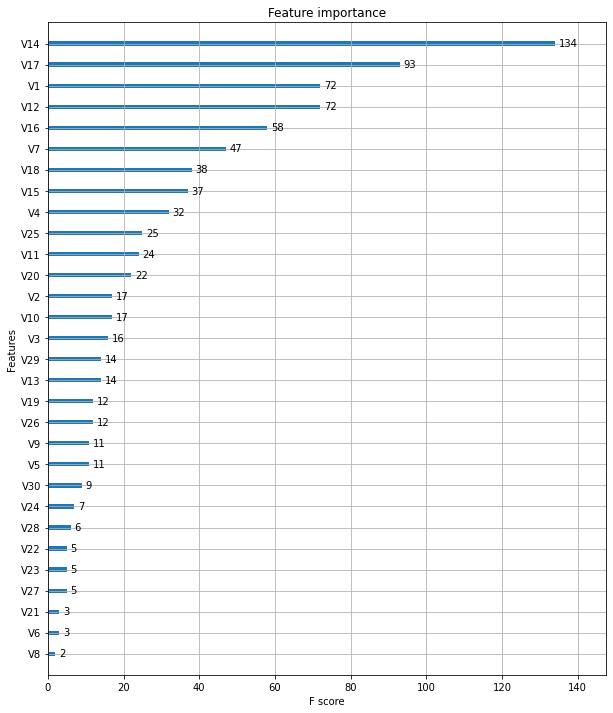

In [22]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(best_clf, ax=ax)

In [23]:
pred_test = best_clf.predict(test_df)

In [24]:
test_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/test.csv')
test_id = test_df['ID'].values.reshape(-1, 1)
final_test_pred = pd.DataFrame(np.concatenate((test_id, pred_test.reshape(-1, 1)), axis=1), columns=['ID', 'Class'])
final_test_pred.head()

,ID,Class
0,AAAA0x1,0
1,AAAA0x2,0
2,AAAA0x5,0
3,AAAA0x7,0
4,AAAA0xc,0


In [25]:
final_test_pred.to_csv('/content/drive/MyDrive/신입기수프로젝트/test_pred_xgboost_2.csv', index = False)